In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pylab as plt
import seaborn as sns
import ast
import glob

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Read Data

In [3]:
IMAGE_LOC = '/nvme/UCIAccData/'

In [4]:
activity_list = [i for i in glob.glob(f'{IMAGE_LOC}/*') if i.find('_') > 0]

In [5]:
activity_list

['/nvme/UCIAccData/Descend_stairs',
 '/nvme/UCIAccData/Use_telephone',
 '/nvme/UCIAccData/Standup_chair',
 '/nvme/UCIAccData/Standup_chair_MODEL',
 '/nvme/UCIAccData/Pour_water',
 '/nvme/UCIAccData/Comb_hair',
 '/nvme/UCIAccData/Walk_MODEL',
 '/nvme/UCIAccData/Pour_water_MODEL',
 '/nvme/UCIAccData/Sitdown_chair',
 '/nvme/UCIAccData/Eat_meat',
 '/nvme/UCIAccData/Climb_stairs',
 '/nvme/UCIAccData/Climb_stairs_MODEL',
 '/nvme/UCIAccData/Eat_soup',
 '/nvme/UCIAccData/Liedown_bed',
 '/nvme/UCIAccData/Brush_teeth',
 '/nvme/UCIAccData/Drink_glass',
 '/nvme/UCIAccData/Getup_bed_MODEL',
 '/nvme/UCIAccData/Drink_glass_MODEL',
 '/nvme/UCIAccData/Getup_bed',
 '/nvme/UCIAccData/Sitdown_chair_MODEL']

In [6]:
def read_data(activity_list):
    '''Read files in each activity in activity_list
    Returns dict: key = activity name -> array of numpy arrays of shape (n_observations, 3) = (ax,ay,az)
    '''
    data = {}
    
    for t in activity_list: #loop over each activity type
        activity_name = t.split('/')[-1]
        data[activity_name] = []
    
        filenames = glob.glob(t + '/*')
        
        for f in filenames: #loop over every participants time-series
            df = pd.read_csv(f, sep=' ', header=None)
            
            #ts = np.sqrt((df**2).sum(axis=1)) #magnitude of acceleration vector
            
            data[activity_name].append(np.array(df))
    
    return data

def get_acceleration_timeseries(data):
    '''Input: data returned by read_data
    Output: dictionary mapping activity name -> list of single time-series of acceleration magnitudes
    '''
    
    data_ts = {}
    
    for k in data:
        data_ts[k] = []
        
        for sample in data[k]: #(ax, ay, az)
            data_ts[k].append(np.sqrt((sample**2).sum(axis=1)))
    
    return data_ts

def get_position_velocity(data):
    '''Input: data returned by read_data
    Output: dictionary mapping activity name -> list of displacement and speed time-series
    '''
    
    data_pos_vel = {}
    
    delta_time = 1 #time-step
    
    for k in data:
        data_pos_vel[k] = []
        
        for acc in data[k]:
            #x = x_0 + vt #constant velocity
            #v = u + at #constant acceleration
            #x = x_0 + ut + 1/2 at^2 #constant acceleration

            #discrete time - assume acceleration constant from step {t-1} to {t}
            #v_{t} = v_{t-1} + a_{t-1} t 
            #x_{t} = x_{t-1} + v_{t-1} t + 1/2 a_{t-1} t^2

            #set time t = 1 (unit). variable called delta_time
    
            #need to initialize p = (x,y,z), v = (vx, vy, vz)
            #assume initial position, velocity = 0
            
            pos, vel = np.zeros_like(acc), np.zeros_like(acc)
            
            for t in range(1, acc.shape[0]):
                vel[t] = vel[t-1] + acc[t-1] * delta_time
                
                pos[t] = pos[t-1] + vel[t-1]*delta_time + (1./2)*acc[t-1]*(delta_time**2)
                
                
            pos = np.sqrt((pos**2).sum(axis=1))
            vel = np.sqrt((vel**2).sum(axis=1))
            
            data_pos_vel[k].append((pos, vel))
            
    return data_pos_vel

In [7]:
data = read_data(activity_list)

In [8]:
data_ts = get_acceleration_timeseries(data)

In [9]:
data_pos_vel = get_position_velocity(data)

# Time-series plots

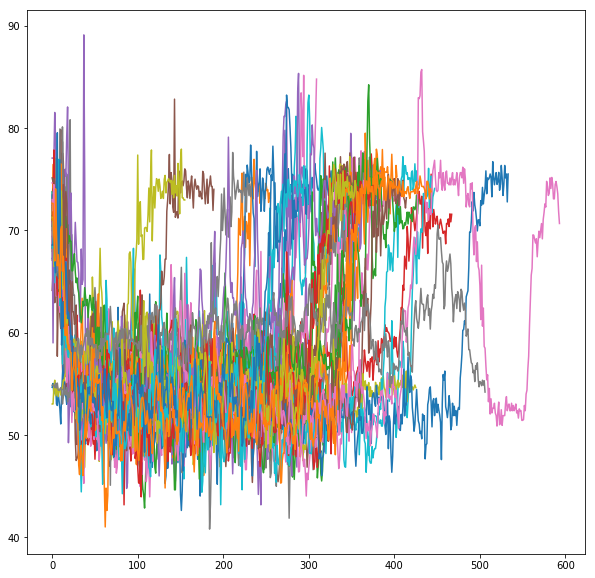

In [10]:
plt.figure(figsize=(10,10))
for elem in data_ts['Descend_stairs']:
    plt.plot(elem)

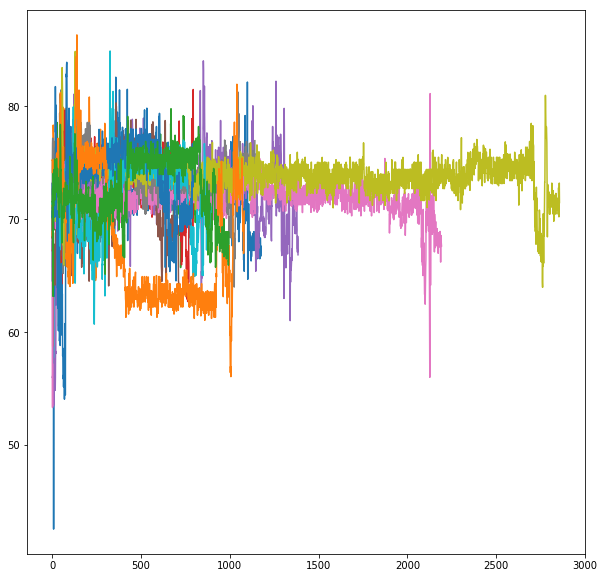

In [11]:
plt.figure(figsize=(10,10))
for elem in data_ts['Use_telephone']:
    plt.plot(elem)

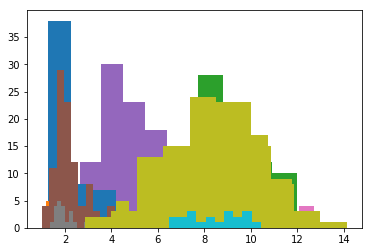

In [12]:
for k in data_ts:
    vols = []
    for val in data_ts[k]:
        vols.append(np.std(val))
        
    plt.hist(vols)

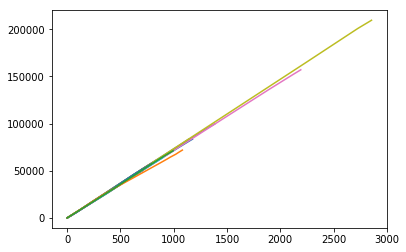

In [13]:
for elem in data_pos_vel['Use_telephone']:
    plt.plot(elem[1])
#for elem in data_pos_vel['Drink_glass']:
#    plt.plot(elem[1])    

In [14]:
#why no negative acc components?
for k in data:
    for elem in data[k]:
        if np.sum(elem < 0) > 0:
            print("Hello")

### Featurizer 1 - statistical properties of acceleration time-series

In [15]:
def featurize_stats(ts, bins):
    #basic statistical measures
    mean = np.mean(ts)
    median = np.median(ts)
    std = np.std(ts)
    length = len(ts)
    kurtosis = scipy.stats.kurtosis(ts)
    
    n,b,p = plt.hist(ts, bins=bins) #need faster implementation with overflow/underflow bins
    n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin
    
    features = {'mean_over_median': mean/median, #dimensionless            
                'std_over_median': std/median, #dimensionless            
                'length': length,
                'kurtosis': kurtosis, #already dimensionless by definition
               }
    for i, val in enumerate(n):
        features[f'binfrac_{i}'] = val
    
    return features

{'mean_over_median': 0.9933543400987399, 'std_over_median': 0.10735163170131132, 'length': 2472, 'kurtosis': 0.49592832932332964, 'binfrac_0': 0.0, 'binfrac_1': 0.0, 'binfrac_2': 0.0, 'binfrac_3': 0.00040551500405515005, 'binfrac_4': 0.009732360097323601, 'binfrac_5': 0.13746958637469586, 'binfrac_6': 0.4464720194647202, 'binfrac_7': 0.3742903487429035, 'binfrac_8': 0.031630170316301706}


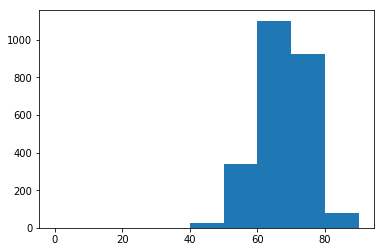

In [16]:
x = featurize_stats(data_ts['Brush_teeth'][0], np.arange(0,100,10))

print(x)

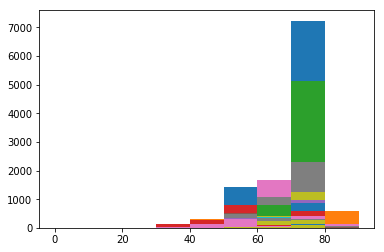

In [17]:
bins = np.arange(0,100,10)

df = []
labels = []

for k in data_ts: #slow, should parallelize
    for elem in data_ts[k]:
        df.append(featurize_stats(elem, bins))
        labels.append(k)

In [18]:
df = pd.DataFrame(df)

In [19]:
df['label'] = labels
df['label'] = df['label'].apply(lambda x: x.replace('_MODEL', ''))

In [20]:
#dirty, sloppy model - no preprocessing, no train/test etc.
model = LogisticRegression()
model.fit(df.drop('label', axis=1), df['label'])

pred = model.predict(df.drop('label', axis=1))
labels = df['label']

print(np.sum(pred==labels) / len(pred)) #chosen at random, accuracy should be ~1/n_classes = 1/20 = 5%

0.6063708759954494


/home/sanjay/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sanjay/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [21]:
model = RandomForestClassifier()

model.fit(df.drop('label', axis=1), df['label'])

pred = model.predict(df.drop('label', axis=1))
labels = df['label']

print(np.sum(pred==labels) / len(pred)) #chosen at random, accuracy should be ~1/n_classes = 1/20 = 5%

0.987485779294653


/home/sanjay/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [22]:
train_df, test_df = train_test_split(df, train_size=0.75)
print(f'train size = {train_df.shape}')
print(f'test size = {test_df.shape}')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

train size = (659, 14)
test size = (220, 14)
Pour_water        99
Getup_bed         98
Sitdown_chair     93
Drink_glass       89
Standup_chair     88
Climb_stairs      87
Descend_stairs    28
Comb_hair         22
Liedown_bed       21
Walk              13
Brush_teeth        8
Use_telephone      8
Eat_meat           3
Eat_soup           2
Name: label, dtype: int64
Climb_stairs      35
Standup_chair     34
Drink_glass       31
Sitdown_chair     27
Getup_bed         23
Pour_water        21
Descend_stairs    14
Comb_hair          9
Walk               7
Liedown_bed        7
Use_telephone      5
Brush_teeth        4
Eat_meat           2
Eat_soup           1
Name: label, dtype: int64


/home/sanjay/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [23]:
model = RandomForestClassifier(max_depth=5, n_estimators=100, n_jobs=10)

model.fit(train_df.drop('label', axis=1), train_df['label'])

train_pred = model.predict(train_df.drop('label', axis=1))
train_labels = train_df['label']
train_acc = np.sum(train_pred==train_labels) / len(train_pred)

test_pred = model.predict(test_df.drop('label', axis=1))
test_labels = test_df['label']
test_acc = np.sum(test_pred==test_labels) / len(test_pred)

print(f'train acc = {train_acc}, test_acc = {test_acc}')

train acc = 0.8148710166919575, test_acc = 0.7227272727272728


Text(0, 0.5, 'predicted')

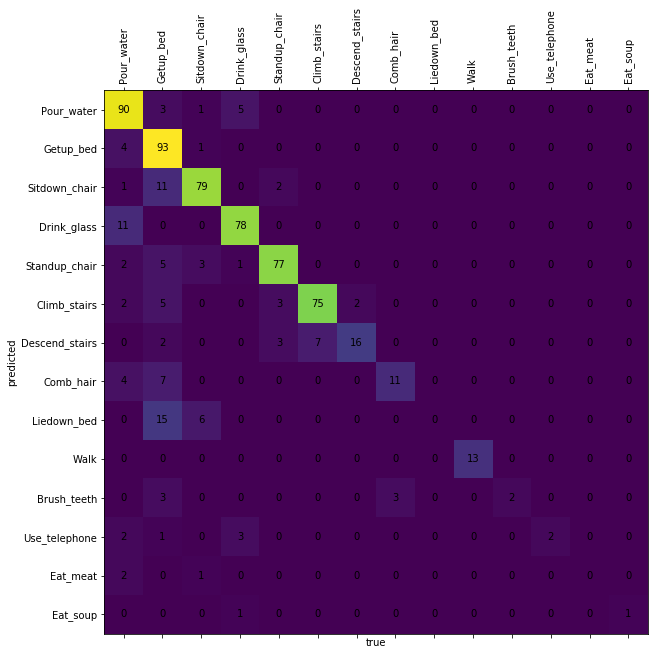

In [24]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot()

labels = list(train_df['label'].value_counts().index)

confusion = confusion_matrix(train_labels, train_pred, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

Text(0, 0.5, 'predicted')

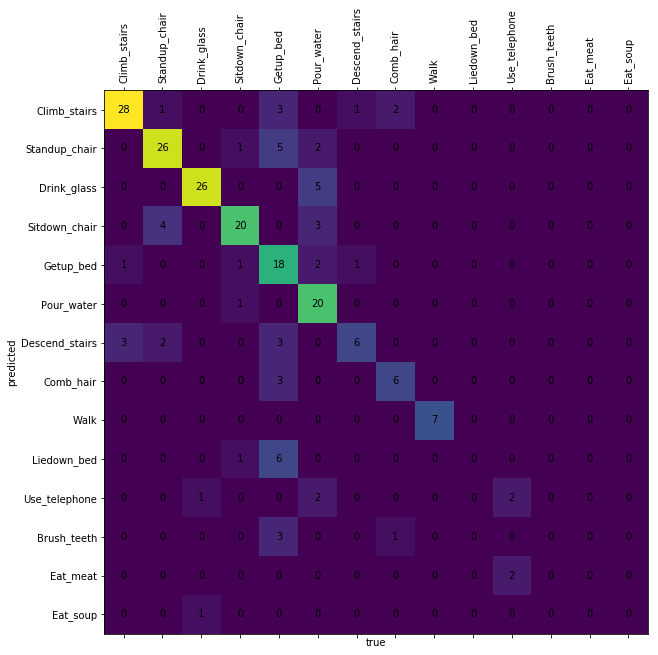

In [25]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot()

labels = list(test_df['label'].value_counts().index)

confusion = confusion_matrix(test_labels, test_pred, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [26]:
#added time-dependent features - redefining function here for convenience (should move to package)
def featurize_stats(ts, bins):
    #basic statistical measures
    mean = np.mean(ts)
    median = np.median(ts)
    std = np.std(ts)
    length = len(ts)
    kurtosis = scipy.stats.kurtosis(ts)
    
    n,b,p = plt.hist(ts, bins=bins) #need faster implementation with overflow/underflow bins
    n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin
    
    features = {'mean_over_median': mean/median, #dimensionless            
                'std_over_median': std/median, #dimensionless            
                'length': length,
                'kurtosis': kurtosis, #already dimensionless by definition
               }
    for i, val in enumerate(n):
        features[f'binfrac_{i}'] = val
    
    #new features
    midpoint = length//2
    
    ts_before = ts[:midpoint]
    ts_after = ts[midpoint:]
    
    mean_before, mean_after = np.mean(ts_before), np.mean(ts_after)
    
    features['mean_over_median_before'] = mean_before/median
    features['mean_over_median_after'] = mean_after/median
    
    return features

def featurize_data(data_ts):
    #featurize
    bins = np.arange(0,100,10)

    df = []
    labels = []

    for k in data_ts: #slow, should parallelize
        for elem in data_ts[k]:
            df.append(featurize_stats(elem, bins))
            labels.append(k)

    df = pd.DataFrame(df)

    df['label'] = labels
    df['label'] = df['label'].apply(lambda x: x.replace('_MODEL', ''))
    
    return df

def create_cv_data(df, train_size=0.75, random_state=None):
    train_df, test_df = train_test_split(df, train_size=train_size, random_state=random_state)
    print(f'train size = {train_df.shape}')
    print(f'test size = {test_df.shape}')

    print(train_df['label'].value_counts())
    print(test_df['label'].value_counts())
    
    return train_df, test_df

def train_sklearn_model(model, train_df, test_df):
    #train model
    model.fit(train_df.drop('label', axis=1), train_df['label'])

    train_pred = model.predict(train_df.drop('label', axis=1))
    train_labels = train_df['label']
    train_acc = np.sum(train_pred==train_labels) / len(train_pred)

    test_pred = model.predict(test_df.drop('label', axis=1))
    test_labels = test_df['label']
    test_acc = np.sum(test_pred==test_labels) / len(test_pred)

    print(f'train acc = {train_acc}, test_acc = {test_acc}')
    
    return model

def plot_confusion_matrix(train_labels, train_pred):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot()

    labels = list(train_labels.value_counts().index)

    confusion = confusion_matrix(train_labels, train_pred, labels=labels)
    ax.matshow(confusion)

    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))

    ax.set_xticklabels(labels, rotation=90);
    ax.set_yticklabels(labels);

    for i in range(len(labels)):
        for j in range(len(labels)):        
            ax.text(j, i, confusion[i,j], va='center', ha='center')

    plt.xlabel('true')
    plt.ylabel('predicted')    
    
    return fig

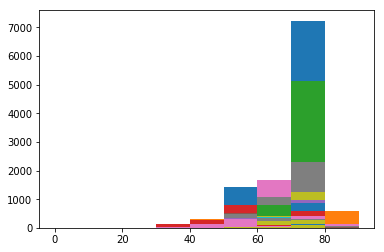

In [27]:
df = featurize_data(data_ts)

In [28]:
train_df, test_df = create_cv_data(df, train_size=0.75, random_state=10)

train size = (659, 16)
test size = (220, 16)
Climb_stairs      98
Getup_bed         95
Standup_chair     94
Drink_glass       88
Sitdown_chair     84
Pour_water        83
Descend_stairs    32
Comb_hair         22
Liedown_bed       21
Walk              17
Brush_teeth       12
Use_telephone     10
Eat_meat           2
Eat_soup           1
Name: label, dtype: int64
Pour_water        37
Sitdown_chair     36
Drink_glass       32
Standup_chair     28
Getup_bed         26
Climb_stairs      24
Descend_stairs    10
Comb_hair          9
Liedown_bed        7
Walk               3
Use_telephone      3
Eat_meat           3
Eat_soup           2
Name: label, dtype: int64


/home/sanjay/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [29]:
#train model
model = RandomForestClassifier(max_depth=5, n_estimators=100, n_jobs=10)

model = train_sklearn_model(model, train_df, test_df)

train acc = 0.8543247344461306, test_acc = 0.8


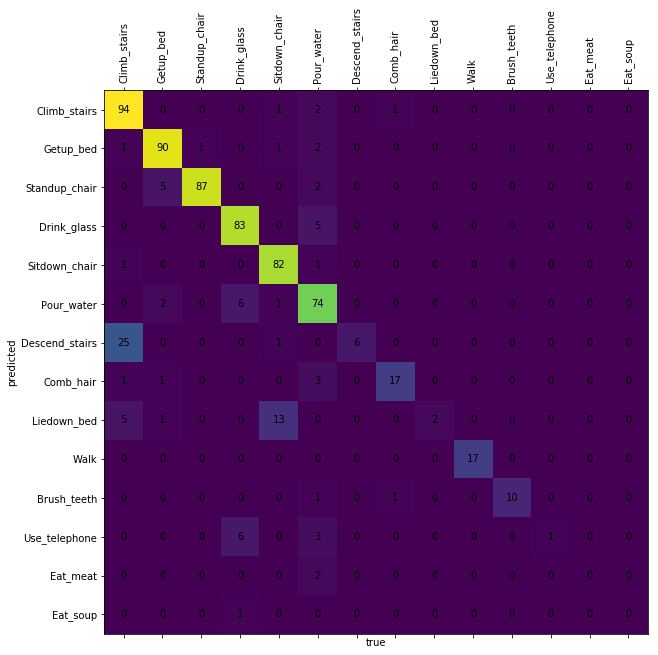

In [30]:
fig = plot_confusion_matrix(train_df['label'], model.predict(train_df.drop('label', axis=1)))

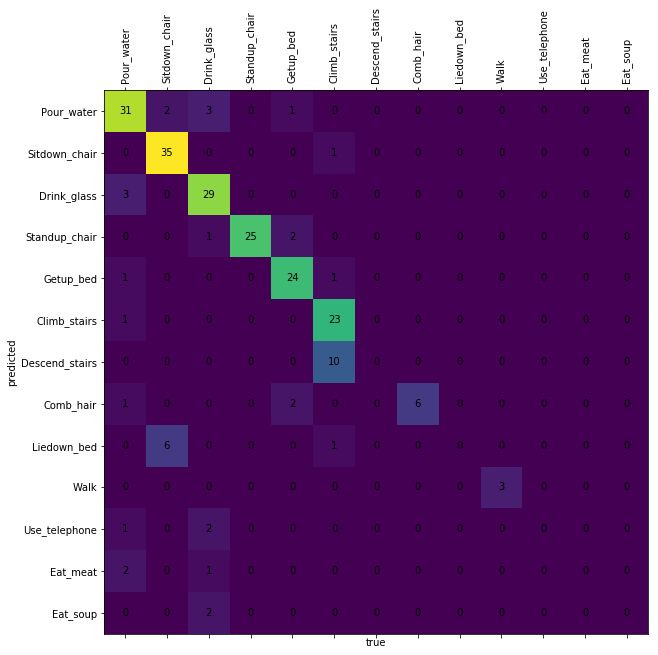

In [31]:
fig = plot_confusion_matrix(test_df['label'], model.predict(test_df.drop('label', axis=1)))

#### Try feed-forward neural net on features

In [40]:
import torch
import torch.nn as nn

In [43]:
cuda_avail = torch.cuda.is_available()
device = torch.device('cuda:0' if cuda_avail else "cpu")

In [44]:
assert(cuda_avail) #remove this line if no GPU

In [106]:
class Net(nn.Module):
    def __init__(self, N_input, N_output, N_hidden_layers, N_hidden_nodes):
        super(Net, self).__init__()
        
        #structure of net
        self.in_layer = nn.Linear(N_input, N_hidden_nodes)
        
        self.hidden = nn.ModuleList([])
        for n_layer in range(N_hidden_layers-1):
            self.hidden.append(nn.Linear(N_hidden_nodes, N_hidden_nodes))
        
        self.out_layer = nn.Linear(N_hidden_nodes, N_output)
        
        #activations
        self.activation = nn.ReLU()
        self.output_activation = nn.LogSoftmax()
        
    def forward(self, x): #x is input vector of shape (batch_size, N_features)
        out = self.activation(self.in_layer(x))
        
        for layer in self.hidden:
            out = self.activation(layer(out))
        out = self.output_activation(self.out_layer(out))
        
        return out
    
def train_torch_model(features, label, model, lr, N_epochs, batch_size=None):
    criterion = nn.NLLLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
    if cuda_avail:
        model = model.to(device)
        features = features.to(device)
        label = label.to(device)
        
    #will change to mini-batch training
    for epoch in range(N_epochs):
        out = model(features)
        loss = criterion(out, label)
        
        if epoch % 1000 == 0:
            print(f'epoch = {epoch} loss = {loss}')
        
        optimizer.zero_grad() #set gradients to zero
        loss.backward() #backward propagation to accumulate gradients
        optimizer.step() #gradient descent step
        
    if cuda_avail:
        model = model.to('cpu')
        features = features.to('cpu')
        label = label.to('cpu')
    
    return model

In [122]:
#DEFINE MODEL
N_input = train_df.shape[1] - 1 #except for labels column
N_output = len(train_df['label'].unique()) #softmax - one for each unique target
N_hidden_layers = 1
N_hidden_nodes = 10

nn_model = Net(N_input, N_output, N_hidden_layers, N_hidden_nodes)

#CONVERT FEATURES, TARGET TO TORCH.TENSORS
train_features = torch.Tensor(np.array(train_df.drop('label', axis=1)))
test_features = torch.Tensor(np.array(test_df.drop('label', axis=1)))

#target should be unique integers for each class
unique_labels = train_df['label'].unique()
labels_to_int_dict = dict(zip(unique_labels, np.arange(len(unique_labels))))
int_to_labels_dict = dict(zip(np.arange(len(unique_labels)), unique_labels))

train_int_labels = train_df['label'].apply(lambda x: labels_to_int_dict[x])
test_int_labels = test_df['label'].apply(lambda x: labels_to_int_dict[x])

train_labels = torch.Tensor(np.array(train_int_labels)).type(torch.LongTensor)
test_labels = torch.Tensor(np.array(test_int_labels)).type(torch.LongTensor)

#TRAIN
N_epochs = 20000
nn_model = train_torch_model(train_features, train_labels, nn_model, 1e-3, N_epochs)

/home/sanjay/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch = 0 loss = 37.66016387939453
epoch = 1000 loss = 2.12264347076416
epoch = 2000 loss = 1.6812245845794678
epoch = 3000 loss = 1.3776744604110718
epoch = 4000 loss = 1.1411348581314087
epoch = 5000 loss = 0.9617674350738525
epoch = 6000 loss = 0.8283592462539673
epoch = 7000 loss = 0.7222175002098083
epoch = 8000 loss = 0.6487258076667786
epoch = 9000 loss = 0.6014387011528015
epoch = 10000 loss = 0.5684242248535156
epoch = 11000 loss = 0.5372539758682251
epoch = 12000 loss = 0.5132229328155518
epoch = 13000 loss = 0.49422910809516907
epoch = 14000 loss = 0.4795950949192047
epoch = 15000 loss = 0.4679117500782013
epoch = 16000 loss = 0.4592601954936981
epoch = 17000 loss = 0.4525071382522583
epoch = 18000 loss = 0.44673487544059753
epoch = 19000 loss = 0.4420532286167145


In [88]:
N_input = train_df.shape[1] - 1 #except for labels column
N_output = len(train_df['label'].unique()) #softmax - one for each unique target
N_hidden_layers = 1
N_hidden_nodes = 10

nn_model = Net(N_input, N_output, N_hidden_layers, N_hidden_nodes)

features = torch.Tensor(np.array(train_df.drop('label', axis=1)))

unique_labels = train_df['label'].unique()
labels_to_int_dict = dict(zip(unique_labels, np.arange(len(unique_labels))))
int_labels = train_df['label'].apply(lambda x: labels_to_int_dict[x])

labels = torch.Tensor(int_labels).type(torch.LongTensor)

N_epochs = 10000
nnmodel = train_model(features, labels, nn_model, 1e-3, N_epochs)

/home/sanjay/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch = 0 loss = 79.04994201660156
epoch = 1000 loss = 2.02115797996521
epoch = 2000 loss = 1.5395793914794922
epoch = 3000 loss = 1.169844150543213
epoch = 4000 loss = 0.9803559184074402
epoch = 5000 loss = 0.8379079699516296
epoch = 6000 loss = 0.7259149551391602
epoch = 7000 loss = 0.6497611403465271
epoch = 8000 loss = 0.6004425883293152
epoch = 9000 loss = 0.5656043887138367


In [123]:
train_pred = [int_to_labels_dict[i] for i in torch.argmax(nn_model(train_features), 1).detach().numpy()]
test_pred = [int_to_labels_dict[i] for i in torch.argmax(nn_model(test_features), 1).detach().numpy()]

/home/sanjay/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [125]:
train_accuracy = np.sum(train_df['label'] == train_pred) / train_df.shape[0]
test_accuracy = np.sum(test_df['label'] == test_pred) / test_df.shape[0]

In [128]:
print(f'train acc = {train_accuracy}, test_acc = {test_accuracy}')

train acc = 0.8285280728376327, test_acc = 0.7909090909090909


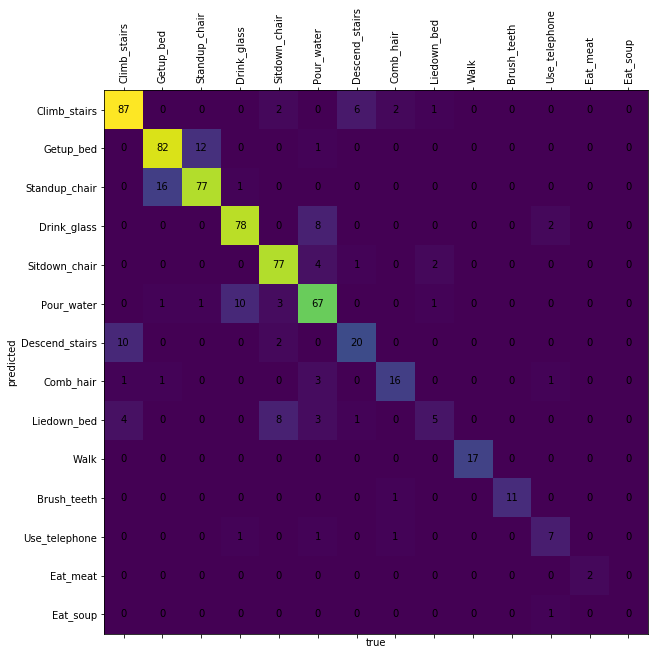

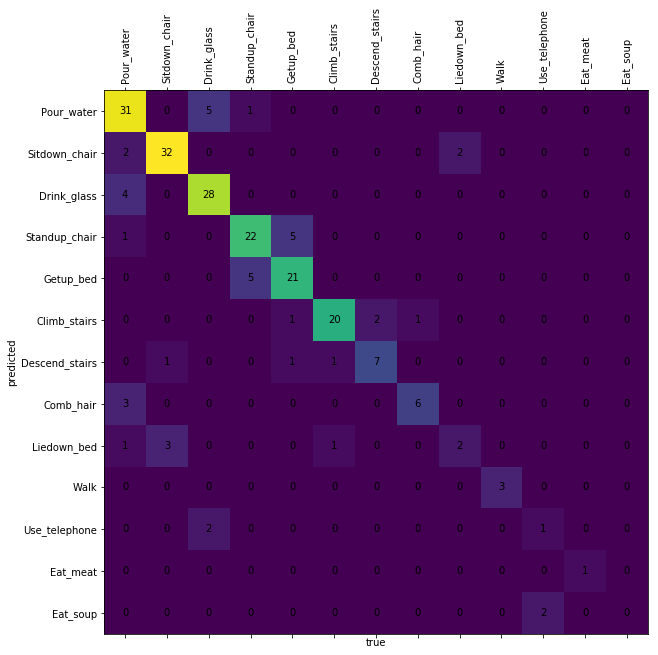

In [130]:
fig = plot_confusion_matrix(train_df['label'], train_pred)
fig = plot_confusion_matrix(test_df['label'], test_pred)

### Featurizer 2 - scaled acceleration time-series

### Featurizer 3 - fourier transforms of raw acceleration time-series

### Featurizer 3 - velocity vs position plots

In [34]:
?plt.hist